### Descriptions:

**Main**: inclusion/exclusion criteria
- have inpatient ID, Hospital encounters
- full code status only (no other code prior to or within 24 hr since admission)
- 18 years and older
- when processing other features, will exclude a few more, mainly those without a complete set of vitals
- add other unprocessed variables from demographics table

**Inputs**: 
- *cohort0* (original init cohort): check years of admission 2015 - 2020
- *encounter* (from SQL) : join with  table to get ESI and inpatient ID information
- *code_status* (from SQL): exclude patients who have any order for EXISTING code status that is not full prior to and within 24hrs after inpatient admission (even if code was cancelled later)
- *demographic*: exclude patients who are < 18 year old

**Outputs**: 
- **cohort1_criteria**
--> this cohort is sent to Tiffany for label processing

OLD -- Modify original's cohort with admit time (UTC) from order_proc and code status. --> Admit time is the earlier from either "Admit to Inpatient" order time from the order_proc table, or from effective time from adt table. When admit time from order_proc is NA, take admit time from ADT table, always available. 

### Importing R libraries

In [5]:
library(caret) # import this before glmnet to avoid rlang version problem
library(xgboost)
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
# library(slam)
library(glmnet)
library(bit64)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
library(mice)
options(repr.matrix.max.rows=200, repr.matrix.max.cols=30)

Loading required package: lattice

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::lift()      masks caret::lift()
✖ dplyr::slice()     masks xgboost::slice()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union





### shc_core
* Use init cohort, with admit_time (this is the effective time < event time for admission) from adt table
* No longer checking for admission order from order_proc because these orders don't have the level of care
* Get inpatient id and acuity_level = ESI from encounter table
* Keep patients with FULL CODE status and >=18 year old
* Keep aptients with admit years from 2015 - 2020

In [1]:
# fread here gives data.table, and read.csv gives dataframe
# cohort <- as.data.frame(cohort) # if use fread

datadir = "../../DataTD"

cohort0 <- read.csv(file.path(datadir, "cohort0.csv"))
nrow(cohort0)  #55383
colnames(cohort0)

cohort0_all <- read.csv(file.path(datadir, "cohort0_all_anon_ids.csv"))
nrow(cohort0_all) # 55402
colnames(cohort0_all)

[1] 55383

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time_jittered" 
[4] "label"

[1] 55402

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time_jittered" 
[4] "label"

In [5]:
dfer <- read.csv(file.path(datadir, "dfer.csv"))
nrow(dfer)  
# colnames(dfer)

[1] 2685583

In [14]:
df <- left_join(cohort0_all, dfer, by = c('anon_id', 'pat_enc_csn_id_coded', 'admit_time_jittered' = 'effective_time_jittered_utc'))
nrow(df)

[1] 64939

In [21]:
cohort0_all %>% group_by(pat_enc_csn_id_coded) %>% 
                            select(pat_enc_csn_id_coded, anon_id) %>% count() %>% arrange(-n) %>% filter(n>1)

pat_enc_csn_id_coded,n
<dbl>,<int>


In [10]:
nrow(anti_join(cohort0, cohort0_all)) #95
nrow(anti_join(cohort0_all, cohort0)) #114
sum(!cohort0$pat_enc_csn_id_coded %in% cohort0_all$pat_enc_csn_id_coded)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time_jittered", "label")



[1] 95

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time_jittered", "label")



[1] 114

[1] 95

In [3]:
# Check admit years
cohort0 <- cohort0 %>% mutate(admit_time = ymd_hms(admit_time_jittered), 
                              adm_year = year(admit_time))
unique(cohort0$adm_year)
nrow(cohort0 %>% filter(adm_year==2021))

[1] 2015 2016 2017 2018 2019 2020

[1] 0

In [4]:
# remove patients with admit year 2021
# rename the label as max level of care at 24 hour
# change to date_time, but when saved, it goes back to factor!
cohort0 <- cohort0 %>% mutate(admit_time = ymd_hms(admit_time_jittered), 
                              adm_year = year(admit_time)) %>% 
                        select(-c(admit_time_jittered, adm_year)) 
nrow(cohort0) #52298 without 2020

[1] 55383

In [5]:
# 1 MRN (patient) can have multiple CSN (visits/encounters)
# but 1 CSN is associated with 1 MRN, might not true for the whole EHR data

nrow(cohort0 %>% distinct(anon_id))
nrow(cohort0 %>% distinct(pat_enc_csn_id_coded))
nrow(cohort0 %>% distinct(anon_id, pat_enc_csn_id_coded))
# nrow(cohort0 %>% group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded) %>% unique()) # unique rows

[1] 36287

[1] 55383

[1] 55383

[1] 36287

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.526   2.000  41.000 

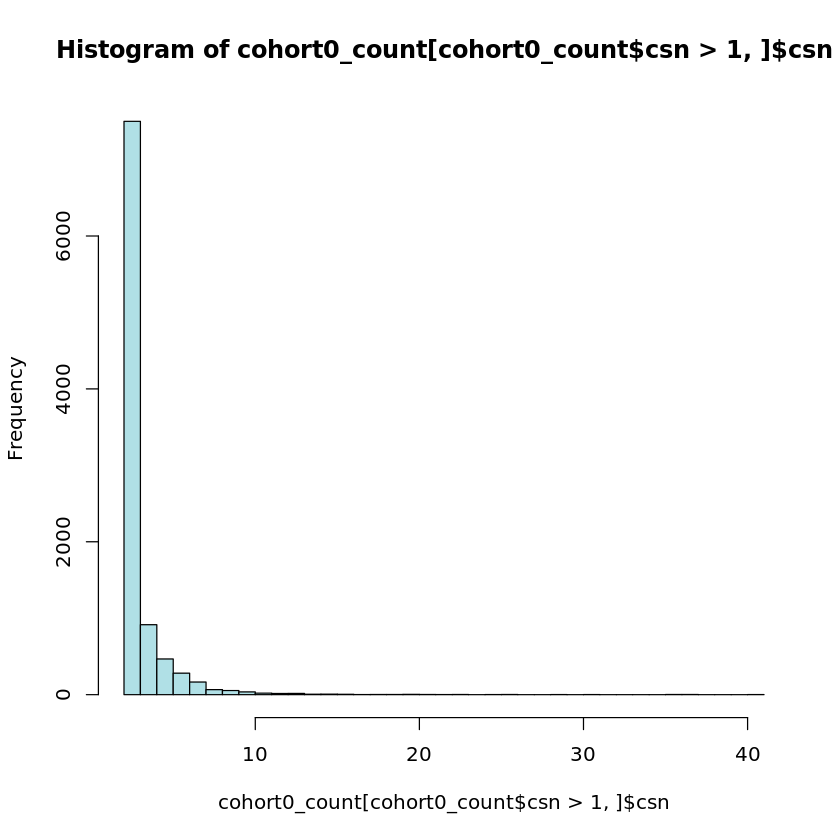

In [6]:
# count how many visits/csn each MRN (anon_id) has
cohort0_count <- cohort0 %>% count(anon_id, sort = TRUE, name = 'csn')
nrow(cohort0_count)
summary(cohort0_count$csn)

# display histogram of freq of patients who have more than 1 visit
hist(cohort0_count[cohort0_count$csn >1, ]$csn, breaks=38, col="powderblue")

In [7]:
head(cohort0_count)

,anon_id,csn
,<chr>,<int>
1,JCe8f38d,41
2,JC29fe299,37
3,JCdc9c9c,37
4,JC2a0d68b,36
5,JCdd32fa,36
6,JCcfe0cb,31


### Encounter, hospital, inpatient IDs
* This table gives us the inpatient id and ESI level
* Either Hospital encounter or empty (NA) type: only keep Hospital Encounter
* All Visit type are NA, as this might be more applicable to outpatient encounters
* Acuity levels are ESI with some missing (~2200)

==> we can remove enc_type and visit_type
* Hospital Admission time (such as ED arrival) is probably before the admit time (to inpatient) from order proc
* Admit time from init cohort is effective_time_jittered_utc, same as Hospital admission time, all times are UTC

In [8]:
enc <- read.csv(file.path(datadir, "encounters.csv"))
nrow(enc)

[1] 55383

In [9]:
enc %>% filter(is.na(inpatient_data_id_coded))

anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,inpatient_data_id_coded,enc_type,visit_type,acuity_level,ACUITY_LEVEL_C,hosp_admsn_time_jittered_utc
<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,<chr>
JC29fea9e,131283506890,2020-03-09 02:48:00+00:00,0,NA,,NA,,NA,
JC2a0a75c,131283296426,2020-01-13 03:38:00+00:00,1,NA,,NA,,NA,
JC2a10dd5,131287909405,2020-03-29 07:10:00+00:00,1,NA,,NA,,NA,
JC2a305eb,131283226027,2020-01-21 03:52:00+00:00,0,NA,,NA,,NA,
JCcbba12,131287849251,2020-03-30 16:39:00+00:00,1,NA,,NA,,NA,
JCd1fa43,131287923845,2020-03-30 19:34:00+00:00,0,NA,,NA,,NA,
JCd2ca79,131288033702,2020-03-31 07:00:00+00:00,0,NA,,NA,,NA,
JCd4996e,131287855587,2020-03-30 08:20:00+00:00,0,NA,,NA,,NA,
JCd58d32,131287959043,2020-03-31 03:24:00+00:00,0,NA,,NA,,NA,


In [10]:
enc %>% gather(var, value) %>% distinct() %>% count(var) %>% arrange(n)

var,n
<chr>,<int>
visit_type,1
enc_type,2
label,2
acuity_level,6
ACUITY_LEVEL_C,6
anon_id,36287
hosp_admsn_time_jittered_utc,54607
admit_time_jittered,54621
inpatient_data_id_coded,55366


In [11]:
summary(enc %>% select(acuity_level, enc_type, visit_type))
summary(enc$ACUITY_LEVEL_C)
# if summary doesn't display, use table
apply(enc[c("acuity_level", "enc_type", "visit_type")], 2, table)

 acuity_level         enc_type         visit_type    
 Length:55383       Length:55383       Mode:logical  
 Class :character   Class :character   NA's:55383    
 Mode  :character   Mode  :character                 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   2.000   3.000   2.641   3.000   5.000    2265 

$acuity_level

                1-Resuscitation      2-Emergent        3-Urgent   4-Semi-Urgent 
           2265             742           18077           33810             470 
   5-Non-Urgent 
             19 

$enc_type

                   Hospital Encounter 
                18              55365 

$visit_type
< table of extent 0 >


Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 55365

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.250   3.500   4.933   5.333 190.433 

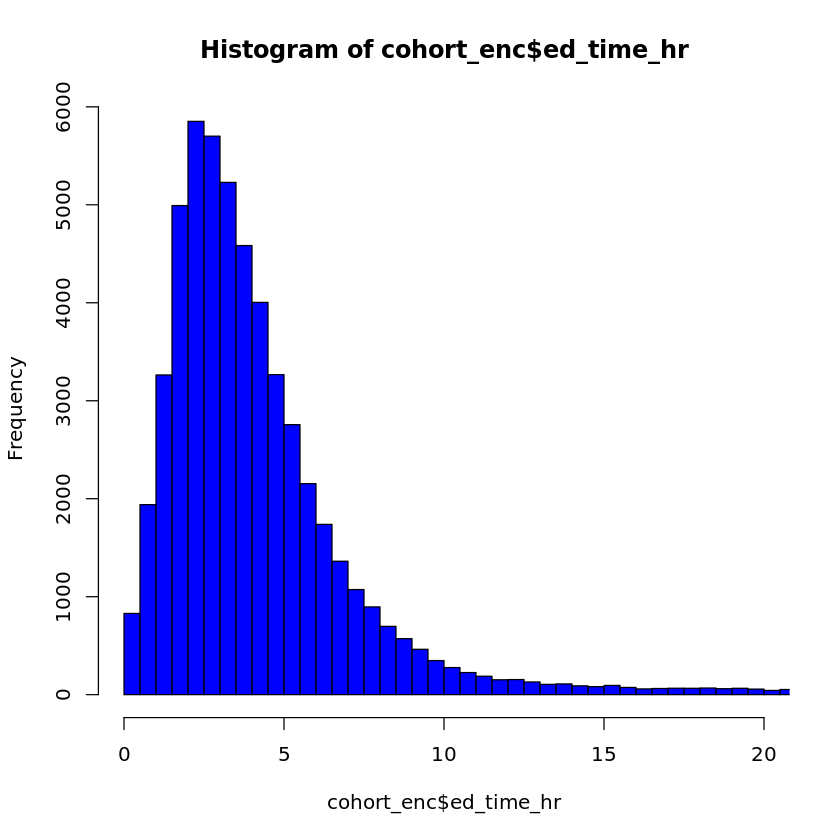

In [12]:
# join the encounter table with cohort table to get the inpatient data id coded
# removed those empty encounter type (18), only Hospital Encounter left
enc <- enc %>% filter(enc_type == "Hospital Encounter") %>%
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                       ESI = ACUITY_LEVEL_C, hosp_admsn_time = hosp_admsn_time_jittered_utc) %>% 
                mutate(hosp_admsn_time = ymd_hms(hosp_admsn_time))

cohort_enc <- inner_join(cohort0, enc) %>% 
            mutate(ed_time_hr = as.numeric(difftime(admit_time, hosp_admsn_time, units ="hours")))

nrow(cohort_enc) # 18 less
summary(cohort_enc$ed_time_hr)
hist(cohort_enc$ed_time_hr, xlim=c(0, 20), breaks=300, col="blue")

### Code status

* Process code status: keep patients whose code status is Full prior to admission or within 24 hour after admission. Otherwise interventions might not match with presentations.
* In other words: remove patients whose have a code status not FULL, anytime before admission or within 24 hour after admission 
* Note that in the display_name, some codes are blank but they are converted to something in description --> use description

In [13]:
# codestatus.csv is from querying code status order from order_proc
code <- read.csv(file.path(datadir, "code_status.csv")) 
nrow(code) # 117195
summary(code %>% select(order_status, display_name, description))

# if summary doesn't display, use table
apply(code[c("order_status", "display_name", "description")], 2, table)

[1] 171195

 order_status       display_name       description       
 Length:171195      Length:171195      Length:171195     
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  

$order_status

         Canceled     Sent 
     208   170804      183 

$display_name

           DNR/C DNR/Comfort Care          DNR/DNE          DNR/DNI 
              58             7086             5511            28119 
       Full code        Full Code     Partial code     Partial Code 
             745           123758                7             5911 

$description

           DNR/C DNR/COMFORT CARE          DNR/DNE          DNR/DNI 
              58             7086             5511            28119 
       FULL CODE     PARTIAL CODE 
          124503             5918 


In [14]:
head(code, n=1) 

,anon_id,pat_enc_csn_id_coded,admit_time_jittered,order_type,order_status,display_name,description,order_time_jittered_utc
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,JC29f8ad2,131274729058,2019-08-31 12:52:00+00:00,Code Status,Canceled,Full Code,FULL CODE,2019-09-01 19:21:00+00:00


In [15]:
code <- code %>% select(anon_id, pat_enc_csn_id_coded, description, order_time = order_time_jittered_utc) %>% 
                    mutate(order_time = ymd_hms(order_time),
                           description = factor(description)) %>% distinct() 
nrow(code) 
summary(code) 

# if summary doesn't display
# table(code$description) # won't show NAs
# summary(code$description)

[1] 83176

   anon_id          pat_enc_csn_id_coded           description   
 Length:83176       Min.   :1.311e+11    DNR/C           :   30  
 Class :character   1st Qu.:1.312e+11    DNR/COMFORT CARE: 3634  
 Mode  :character   Median :1.312e+11    DNR/DNE         : 2780  
                    Mean   :1.312e+11    DNR/DNI         :14021  
                    3rd Qu.:1.313e+11    FULL CODE       :59935  
                    Max.   :1.313e+11    PARTIAL CODE    : 2776  
   order_time                 
 Min.   :2015-01-01 05:27:00  
 1st Qu.:2016-06-01 22:09:45  
 Median :2018-01-14 08:04:30  
 Mean   :2017-10-20 16:00:34  
 3rd Qu.:2019-02-28 06:45:15  
 Max.   :2020-03-31 07:00:00  

In [16]:
# calculate the difference btwn admit time and code status order time
code <- left_join(cohort_enc, code) %>% 
            mutate(code_diff_hr = as.numeric(difftime(order_time, admit_time, units = 'hours')))

nrow(code %>% group_by(anon_id, pat_enc_csn_id_coded) %>% unique())
nrow(code %>% select(anon_id, pat_enc_csn_id_coded) %>% group_by(anon_id, pat_enc_csn_id_coded) %>% unique()) 

Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 88820

[1] 55365

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-181.050    1.083    2.533   50.912   39.100 5568.317     5668 

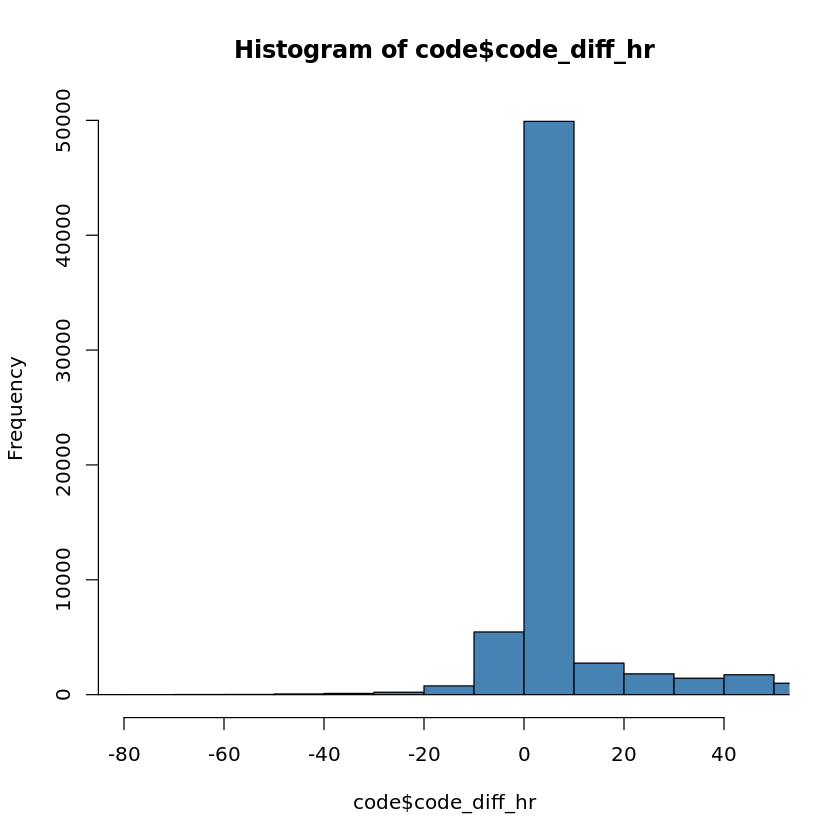

In [17]:
# code order time is prior to or within 24 hours after admission, time diff in hours (code time - admit time)
summary(code$code_diff_hr)
hist(code$code_diff_hr,  xlim=c(-80, 48), breaks=720, col="steelblue")

In [18]:
# number of patients whose code status are either full or na (if exists, consider na = FULL) 
nrow(filter(code, description != "FULL CODE" & !is.na(description))) # to be removed

# cohort of patients whose code status before admission or 24 hour after admission is not FULL CODE
code_notfull <- code %>% 
                filter(code_diff_hr <=24 & description != "FULL CODE" & !is.na(description)) %>% 
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, admit_time) %>%
                distinct()

# number of patients whose code status is not full 24
nrow(code_notfull)
nrow(code_notfull %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) # 6341 for 2015-2018

[1] 23232

[1] 9045

[1] 9045

In [19]:
# remove 9045 non-fullcode, non-na code patients from the cohort
cohort_code <- anti_join(cohort_enc, code_notfull) 
nrow(cohort_code) # 46320
nrow(unique(cohort_code %>% select(anon_id, pat_enc_csn_id_coded))) 
nrow(filter(cohort_code, is.na(admit_time)))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "inpatient_data_id_coded")



[1] 46320

[1] 46320

[1] 0

In [20]:
head(cohort_code, n=1)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr
,<chr>,<dbl>,<int>,<dttm>,<dbl>,<dbl>,<dttm>,<dbl>
1,JCe78a06,131062667066,0,2015-01-02 01:01:00,13616753,NA,2015-01-01 17:10:00,7.85


### Age from demographic variables
1. Age (only >=18)
2. insurance = Medical/care/caid and n/a insurance --> medis =1 otherwise 0
3. language --> Engl = 1 for English, otherwise 0
4. leave height and weight to be processed with flowsheet age (>=18 only)

In [21]:
demo <- read.csv(file.path(datadir, "demographics.csv")) %>% distinct()
nrow(demo)
summary(demo)

[1] 36179

   anon_id             gender              race             language        
 Length:36179       Length:36179       Length:36179       Length:36179      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
 recent_height_cm recent_weight_kg  insurance         recent_date       
 Min.   : 12.7    Min.   :  0.00   Length:36179       Length:36179      
 1st Qu.:160.0    1st Qu.: 60.30   Class :character   Class :character  
 Median :167.6    Median : 72.50   Mode  :character   Mode  :character  
 Mean   :167.5    Mean   : 75.56                                        
 3rd Qu.:175.3    3

In [22]:
head(demo)

,anon_id,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,dob
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,JC29f8ad2,Female,White,English,165.1,83.46,UNITED HEALTHCARE,2020-03-31,1968-01-23
2,JC29f8ad3,Female,Asian,English,NA,NA,BLUE CROSS,2020-02-24,1984-12-07
3,JC29f8b9c,Male,Unknown,,NA,NA,,2019-01-12,1960-01-21
4,JC29f8beb,Female,White,English,154.9,65.40,CIGNA,2019-12-22,1989-06-19
5,JC29f8bef,Female,Asian,English,156.0,51.70,UNITED HEALTHCARE,2020-03-31,1959-07-05
6,JC29f8c35,Male,White,English,163.6,85.65,,2020-03-13,1947-06-03


In [23]:
# calculate age, only keep patients age >=18, (304 < 18)
cohort_age <- left_join(cohort_code, demo) %>%
                    mutate(dob = ymd(dob), recent_date = ymd(recent_date), gender = factor(gender), 
                           race = factor(race), language = factor(language), insurance = factor(insurance),
                           age = round(as.numeric(difftime(ymd_hms(admit_time), dob, units="days")/365),0)) %>%
                    filter(age >= 18) %>% select(-dob)
nrow(cohort_age)
summary(cohort_age)

Joining, by = "anon_id"



[1] 45986

   anon_id          pat_enc_csn_id_coded     label      
 Length:45986       Min.   :1.311e+11    Min.   :0.000  
 Class :character   1st Qu.:1.312e+11    1st Qu.:0.000  
 Mode  :character   Median :1.312e+11    Median :0.000  
                    Mean   :1.312e+11    Mean   :0.138  
                    3rd Qu.:1.313e+11    3rd Qu.:0.000  
                    Max.   :1.313e+11    Max.   :1.000  
                                                        
   admit_time                  inpatient_data_id_coded      ESI       
 Min.   :2015-01-01 08:24:00   Min.   :13616753        Min.   :1.000  
 1st Qu.:2016-05-22 19:15:45   1st Qu.:19863571        1st Qu.:2.000  
 Median :2017-12-31 03:18:00   Median :27889292        Median :3.000  
 Mean   :2017-10-13 04:34:25   Mean   :28152729        Mean   :2.655  
 3rd Qu.:2019-02-19 03:23:45   3rd Qu.:34369529        3rd Qu.:3.000  
 Max.   :2020-03-31 07:00:00   Max.   :48026130        Max.   :5.000  
                                               

In [24]:
# checking duplicates
nrow(cohort_age %>% select(anon_id) %>% distinct()) # 30073
nrow(cohort_age %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) # 43524
cohort_demo[duplicated(cohort_age[, c('anon_id','pat_enc_csn_id_coded')]),]

# cohort_demo %>% filter(anon_id == "JCd49287") # pat_enc_csn_id_coded = 131195706986, 
# cohort_demo <- cohort_demo %>% filter (!(anon_id == "JCd49287" & race == "Unknown"))

[1] 31584

[1] 45986

anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age
<chr>,<dbl>,<int>,<dttm>,<dbl>,<dbl>,<dttm>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<date>,<dbl>


In [25]:
summary(cohort_age %>% select(ESI, gender, race, recent_height_cm, recent_weight_kg, age))
cohort_age %>% gather(var, value) %>% distinct() %>% count(var) %>% arrange(n)
cohort_age %>% summarise_each(funs(n_distinct))
# cohort_demo %>% summarise(across(all_of(.), count))

      ESI           gender                    race       recent_height_cm
 Min.   :1.000   Female:21997   Asian           : 6906   Min.   : 12.95  
 1st Qu.:2.000   Male  :23989   Black           : 3279   1st Qu.:160.02  
 Median :3.000                  Native American :  194   Median :167.64  
 Mean   :2.655                  Other           :10554   Mean   :167.97  
 3rd Qu.:3.000                  Pacific Islander:  943   3rd Qu.:175.26  
 Max.   :5.000                  Unknown         :  426   Max.   :210.82  
 NA's   :1861                   White           :23684   NA's   :1420    
 recent_weight_kg      age       
 Min.   :  0.10   Min.   :18.00  
 1st Qu.: 60.90   1st Qu.:44.00  
 Median : 73.10   Median :60.00  
 Mean   : 76.61   Mean   :58.28  
 3rd Qu.: 88.00   3rd Qu.:73.00  
 Max.   :320.69   Max.   :90.00  
 NA's   :311                     

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


var,n
<chr>,<int>
gender,2
label,2
ESI,6
race,7
language,55
age,73
insurance,134
recent_date,457
recent_height_cm,790


Warning message:
“`summarise_each_()` was deprecated in dplyr 0.7.0.
Please use `across()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
31584,45986,2,45451,45986,6,45473,2076,2,7,55,790,3448,134,457,73


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.00   44.00   60.00   58.28   73.00   90.00 

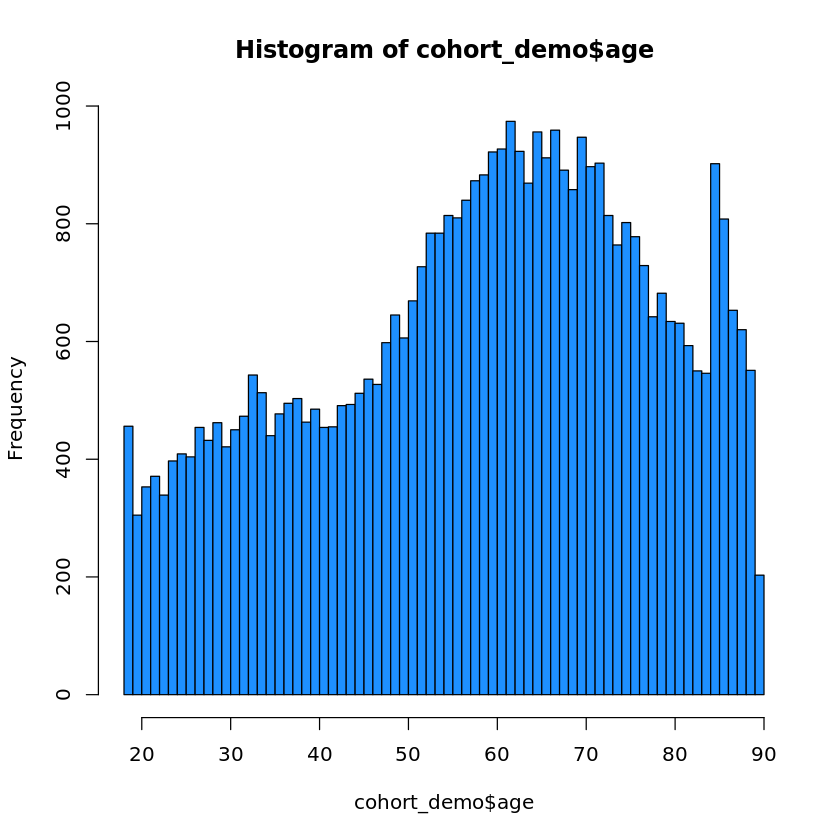

In [26]:
summary(cohort_age$age)
hist(cohort_age$age, breaks=100, col="dodgerblue")

In [27]:
# this is the updated cohort meeting encounter/codestatus/age criteria
write.csv(cohort_age, file = file.path(datadir, "cohort1_criteria.csv"), row.names=FALSE)

In [29]:
head(cohort_age)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age
,<chr>,<dbl>,<int>,<dttm>,<dbl>,<dbl>,<dttm>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<date>,<dbl>
1,JCe78a06,131062667066,0,2015-01-02 01:01:00,13616753,NA,2015-01-01 17:10:00,7.850000,Female,White,English,152.40,55.60,HEALTHNET SENIOR ADVANTAGE,2020-01-10,83
2,JCd1c19e,131062745090,0,2015-01-03 05:53:00,13628503,3,2015-01-03 01:56:00,3.950000,Female,White,English,154.50,49.20,BLUE SHIELD,2020-03-31,53
3,JCd91eb2,131062747648,0,2015-01-01 08:24:00,13628701,2,2015-01-01 01:10:00,7.233333,Female,White,English,170.18,92.70,MEDICARE,2019-01-01,64
4,JCe7cb4d,131062788358,0,2015-01-01 23:39:00,13631833,3,2015-01-01 17:07:00,6.533333,Male,White,English,185.42,101.90,AETNA,2019-01-01,25
5,JCe293de,131063044001,0,2015-01-05 02:23:00,13663181,3,2015-01-04 18:13:00,8.166667,Female,Other,Spanish,152.40,40.37,COMMERCIAL OTHER,2019-01-01,34
6,JCe8d756,131063080858,0,2015-01-07 04:00:00,13668812,2,2015-01-06 22:24:00,5.600000,Male,White,English,170.18,68.67,BLUE CROSS,2019-01-01,68
